<h2> Dieses Notebook führt die Volumenschätzung ausschließlich aus Basis der Tiefenwerte, intrinsischen Matrix und referenz Dimensionen aus, welche direkt aus dem IPhone via Apple SDK gewonnen wurden.

# Import der Libraries

In [2]:
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
import glob
from camera_intrinsic import get_camera_intrinsics
from exif_extract import transform_jpeg_to_depthmap_samsungs20
from exif_extract import transform_jpeg_to_depthmap_iphone
from binary_dm import transform_binary_to_depthmap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Tiefenkarte lesen und plotten

Einlesen der Binary

In [3]:
binary_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\Banane1_16Lidar\DepthMap.bin"
depth_map = transform_binary_to_depthmap(binary_url)

In [4]:
print(depth_map.dtype)


float16


Einlesen des RGB image

In [5]:
rgb_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\color_image.jpg"
rgb_im = Image.open(rgb_url)

In [6]:
rgb_height, rgb_width =rgb_im.size
rgb_height

1920

Plotten der Tiefenkarte

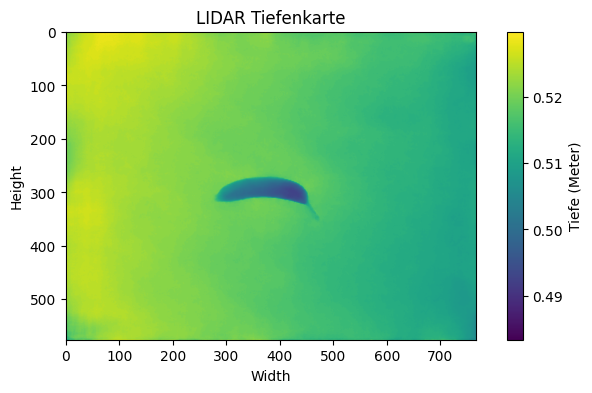

In [7]:
plt.figure(figsize=(8, 4))
plt.imshow(depth_map, cmap = "viridis")
plt.colorbar(label="Tiefe (Meter)")
plt.title("LIDAR Tiefenkarte")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


In [8]:
depth_map.size

442368

We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [9]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

# Exiftool camera calibration

In [10]:
dm_height, dm_width= depth_map.shape
dm_height

576

intrinsische Matrix

In [11]:
intrinsic_matrix = np.array([
    [2943.626708984375, 0, 2006.96923828125],
    [0, 2943.626708984375, 1519.7119140625],
    [0, 0, 1]
])

print(intrinsic_matrix)


[[2.94362671e+03 0.00000000e+00 2.00696924e+03]
 [0.00000000e+00 2.94362671e+03 1.51971191e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Referenzdimensionen für die Skalierung der intrinsischen Matrix

In [12]:
#OriginalWerte
# ref_height = 4032
# ref_width = 3024

In [13]:
#Diese Werte nutze ich zum testen, da die Tiefekarte gekippt ist, sind auch höhe und breite vertauscht
ref_height = 3024
ref_width = 4032

In [14]:
# sclaingfactor
scale_x = dm_width / ref_width
scale_y = dm_height / ref_height

# scaling
scaled_mtx = intrinsic_matrix.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[560.69080171   0.         382.27985491]
 [  0.         560.69080171 289.46893601]
 [  0.           0.           1.        ]]


because the depthmap is already processes by the IPhone and normalized, I have to scale to numbers back to meters. the maximum depth captured by the LIDAR sensor seems to be 5 meters.
so the maximum value of the unedited array, which is 255, is equal to 5 meters while 0 = 0 meters.

scaled intrinsic

In [15]:
fx = scaled_mtx[0, 0]
fy = scaled_mtx[1, 1]
cx = scaled_mtx[0, 2]
cy = scaled_mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width, height=dm_height, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 560.6908017113095, fy: 560.6908017113095, cx: 382.2798549107143, cy: 289.46893601190476


# Create point cloud

Open3D Object without metric scaling

In [16]:
depth_data_uint16_Iphone = (depth_map.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

In [17]:
depth_image = o3d.geometry.Image(depth_map.astype(np.float32))

Pointcloud

In [18]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # 
    depth_trunc=3.0,  # Maximal erlaubte Tiefe. 3 Meter reichen für unsere Ansprüche.
    stride=1  # Jeder Pixel wird genutztbei Stride = 1
)


In [19]:
o3d.visualization.draw_geometries([pcd])

In [20]:
num_points = len(np.asarray(pcd.points))
print(f"Anzahl der Punkte in der Punktwolke: {num_points}")

Anzahl der Punkte in der Punktwolke: 442368


# Clean Point Cloud

## Estimating normals

In [21]:
nn_distance = np.mean(pcd.compute_nearest_neighbor_distance())

print(nn_distance)

0.0009147431093448308


In [22]:
radius_normals = nn_distance * 4

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd.paint_uniform_color([0.6, 0.6, 0.6])
o3d.visualization.draw_geometries([pcd])

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [23]:
pcd_center = pcd.get_center()
pcd.translate(pcd_center)

PointCloud with 442368 points.

## Plane segmentation with RANSAC

In [24]:
plane_model, inliers = pcd.segment_plane(
    distance_threshold=0.0045,
    ransac_n=10,
    num_iterations=6000,
    probability=1
)

[a, b, c, d] = plane_model.tolist()

# Inlier- und Outlier-Punktwolken
pcd_plane = pcd.select_by_index(inliers)
inlier_cloud = pcd_plane.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)

# Darstellung der Punktwolken
o3d.visualization.draw_geometries(
    [inlier_cloud, outlier_cloud])


In [50]:
pcd_object = outlier_cloud

Punktwolke der flachen Ebene

In [26]:
o3d.visualization.draw_geometries([pcd_plane], window_name="RANSAC Plane") 

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

In [27]:
#Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Removing the outliers

In [28]:
cl, ind = pcd_object.remove_statistical_outlier(nb_neighbors=1500, std_ratio=1.0) #gute Ergebnisse mit diesen Werten bisher

Displaying inlier in grey and outlier in red

In [29]:
display_inlier_outlier(pcd_object, ind)

Showing outliers (red) and inliers (gray): 


We will use this PC from now on

In [ ]:
# Cleaned PC
pcd_object = pcd_object.select_by_index(ind)  # Nur Inlier
pcd_object_copy = pcd_object.select_by_index(ind)

Clean Plane too 

In [31]:
cl, ind = pcd_plane.remove_statistical_outlier(nb_neighbors=1500, std_ratio=1.0) #gute Ergebnisse mit diesen Werten bisher

In [32]:
display_inlier_outlier(pcd_plane, ind)

Showing outliers (red) and inliers (gray): 


In [33]:
# Cleaned PC
pcd_plane = pcd_plane.select_by_index(ind)  # Nur Inlier

In [34]:
plane_array = np.asarray(pcd_plane.points) 

In [35]:
o3d.visualization.draw_geometries([pcd_plane])


Visualizing the new PC of the object

In [36]:
o3d.visualization.draw_geometries([pcd_object])

Punktwolke des Lebensmittels

In [37]:
pcd_object_array = np.asarray(pcd_object.points)
pcd_object_array

array([[-0.00913688, -0.01896302,  1.03064657],
       [-0.00822248, -0.01896302,  1.03064657],
       [-0.00730174, -0.01894694,  1.03015829],
       ...,
       [ 0.06200674,  0.02849814,  1.02918173],
       [ 0.06291852,  0.02849814,  1.02918173],
       [ 0.06291852,  0.02940993,  1.02918173]])

## Punktwolke berichtigen

Das Problem beim Extrahieren des jeweiligen Lebensmittels ist, dass, da nicht alle Punkte in der Tiefenkarte sichtbar sind, diese Punkte fehlen und das Objekt an Höhe verliert, sobald man den RANSAC-Algorithmus ausführt.
Um die korrekte Höhe beizubehalten, kann man das Lebensmittel bis zur ebenen Fläche erweitern und somit vervollständigen.  

Visualisierung der Achsen

In [38]:
# Achsenvisualisierung hinzufügen
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

# Punktwolke zeichnen mit Achsen
o3d.visualization.draw_geometries([pcd_plane, mesh_frame])

Wir benötigen die untersten Punkte der Objekt-Punktwolke

In [39]:
# Maximalen z-Wert des Objekts bestimmen
max_z_object = np.max(pcd_object_array[:, 2])

print(f"Tiefster z-Wert des Objekts: {max_z_object}")

Tiefster z-Wert des Objekts: 1.0321114140528218


In [40]:
# Durchschnitt
avg_z_plane = plane_array[:, 2].mean()
print(f"Tiefster z-Wert der Ebene: {avg_z_plane}")

Tiefster z-Wert der Ebene: 1.036117863101037


In [41]:
# Minimalen z-Wert der Ebene bestimmen
max_z_plane = plane_array[:, 2].min()
print(f"Tiefster z-Wert der Ebene: {max_z_plane}")

Tiefster z-Wert der Ebene: 1.0247871953028218


In [42]:
# Threshold für die Bestimmung der unteren Punkte des Objekts
threshold = 0.003

# 1. Tiefste Punkte des Objekts erhalten
bottom_edge = []

for row in pcd_object_array:
    if abs(row[2] - max_z_object) < threshold:  
        bottom_edge.append(row.tolist())  # "tolist()" konvertiert die numpy-Row in eine Liste für bessere Performance

bottom_edge = np.array(bottom_edge)  # Am Ende in ein numpy-Array umwandeln


# 3. Punktwolke in Open3D erstellen
bottom_edge_pcd = o3d.geometry.PointCloud()
bottom_edge_pcd.points = o3d.utility.Vector3dVector(bottom_edge)

o3d.visualization.draw_geometries([bottom_edge_pcd])

In [43]:
# 4. Punkte in Z-Richtung erweitern
new_points = []

for x, y, z in bottom_edge:
    current_z = z  # Starte mit der aktuellen Höhe
    print(f"tiefster wert plane:{avg_z_plane}")
    print(f"current z:{current_z}")
    while current_z < avg_z_plane:  
        current_z += 0.0001
        print(f"current z erweitert:{current_z}")
        if current_z > avg_z_plane:  # Falls wir zu weit gehen, abbrechen
            break
        new_points.append([x, y, current_z])

# 5. Neue Punkte zur Open3D Punktwolke hinzufügen
new_points = np.array(new_points)  # Am Ende in ein numpy-Array umwandeln

# 6. Ausgabe
print(f"Anzahl ursprünglicher Punkte: {len(bottom_edge)}")
print(f"Anzahl neuer Punkte: {len(new_points)}")
print(f"Gesamtanzahl Punkte in der Punktwolke: {len(pcd.points)}")

# 7. Punktwolke der neuen Punkte visualisieren

new_points_pcd = o3d.geometry.PointCloud()
new_points_pcd.points = o3d.utility.Vector3dVector(new_points)

o3d.visualization.draw_geometries([new_points_pcd])

tiefster wert plane:1.036117863101037
current z:1.0306465703028218
current z erweitert:1.0307465703028218
current z erweitert:1.0308465703028218
current z erweitert:1.0309465703028218
current z erweitert:1.0310465703028218
current z erweitert:1.0311465703028218
current z erweitert:1.0312465703028217
current z erweitert:1.0313465703028217
current z erweitert:1.0314465703028217
current z erweitert:1.0315465703028217
current z erweitert:1.0316465703028217
current z erweitert:1.0317465703028217
current z erweitert:1.0318465703028217
current z erweitert:1.0319465703028217
current z erweitert:1.0320465703028217
current z erweitert:1.0321465703028216
current z erweitert:1.0322465703028216
current z erweitert:1.0323465703028216
current z erweitert:1.0324465703028216
current z erweitert:1.0325465703028216
current z erweitert:1.0326465703028216
current z erweitert:1.0327465703028216
current z erweitert:1.0328465703028216
current z erweitert:1.0329465703028216
current z erweitert:1.03304657030282

In [44]:
o3d.visualization.draw_geometries([new_points_pcd, pcd_plane])

In [45]:
pcd_object.points.extend(o3d.utility.Vector3dVector(new_points))
o3d.visualization.draw_geometries([pcd_object])


Punkte generieren Quelle: https://stackoverflow.com/questions/65774814/adding-new-points-to-point-cloud-in-real-time-open3d

In [92]:
# Punktwolke in Open3D-Format umwandeln
new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(bottom_edge)  # NumPy → Open3D

# Punktwolke anzeigen
o3d.visualization.draw_geometries([new_pcd])

# Zusammenfassung der Punktwolke

## Ausdehnung des Objekts

In [46]:
bounds = pcd_object.get_max_bound() - pcd_object.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.2f}, y={bounds[1]:.2f}, z={bounds[2]:.2f}")

Ausdehnung der Punktwolke: x=0.16, y=0.05, z=0.03


# Volumenberechnung

## Bounding Box

In [255]:
import open3d as o3d
import numpy as np


# 🟥 1️⃣ Axis-Aligned Bounding Box (AABB) berechnen und visualisieren
aabb = pcd_object.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)  # Rot

# 🟩 2️⃣ Oriented Bounding Box (OBB) berechnen
oriented_bb = pcd_object.get_oriented_bounding_box()
oriented_bb.color = (0, 1, 0)  # Grün

# 🖼 3️⃣ Bounding-Boxen und Punktwolke visualisieren
o3d.visualization.draw_geometries([pcd_object, aabb, oriented_bb])

# 📦 4️⃣ Volumenberechnung der OBB
obb_extents = oriented_bb.extent
obb_volume = obb_extents[0] * obb_extents[1] * obb_extents[2]

print(f"📦 Volumen der Oriented Bounding Box (OBB): {obb_volume:.2f}")

# 📏 5️⃣ Debugging: Bounding-Box-Größe prüfen
min_bound = pcd_object.get_min_bound()
max_bound = pcd_object.get_max_bound()
print(f"Min Bound: {min_bound}, Max Bound: {max_bound}")
print(f"AABB Größe: {aabb.get_extent()}")
print(f"OBB Größe: {obb_extents}")

obb_volume = np.prod(obb_extents)
print(f"📦 Korrigiertes OBB-Volumen: {obb_volume:.6f} m³")


📦 Volumen der Oriented Bounding Box (OBB): 0.00
Min Bound: [-0.09352622 -0.0189791   1.01062704], Max Bound: [0.06291852 0.02940993 1.03211141]
AABB Größe: [0.15644474 0.04838904 0.02148438]
OBB Größe: [0.15625233 0.04847083 0.02392854]
📦 Korrigiertes OBB-Volumen: 0.000181 m³


## Alpha shapes

In [47]:
# Quelle Code: https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html
# Quelle Theorie:  [Edelsbrunner1983] Edelsbrunner and D. G. Kirkpatrick and R. Seidel: On the shape of a set of points in the plane, IEEE Transactions on Information Theory, 29 (4): 551–559, 1983

alpha = 0.1
print(f"alpha={alpha:.3f}")
alpha_shape  = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd_object, alpha)
alpha_shape .compute_vertex_normals()
o3d.visualization.draw_geometries([alpha_shape], mesh_show_back_face=True)



alpha=0.100
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra 

In [48]:
# Volumenberechnung mit Tetrahedron Decomposition (Delaunay Triangulation)
def compute_mesh_volume(mesh):
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    
    volume = 0.0
    for tri in triangles:
        v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]
        tetra_volume = np.dot(v0, np.cross(v1, v2)) / 6.0  # Volumen eines Tetraeders
        volume += tetra_volume
    
    return abs(volume)

# Volumen berechnen
volumen = compute_mesh_volume(alpha_shape)
print(f"Volumen des Alpha Shapes: {volumen:.5f} m³")


Volumen des Alpha Shapes: 0.00163 m³


## Poisson surface reconstruction

{
	"class_name" : "ViewTrajectory",
	"interval" : 29,
	"is_loop" : false,
	"trajectory" : 
	[
		{
			"boundingbox_max" : [ 0.37266316311358966, 0.27607654526499509, 1.0598434601668958 ],
			"boundingbox_min" : [ -0.36875796693473462, -0.25416191307374658, 0.97756806954189579 ],
			"field_of_view" : 60.0,
			"front" : [ 0.057116457826188981, -0.95183024273921635, -0.3012588575501039 ],
			"lookat" : [ 0.0019525980894275208, 0.010957316095624253, 1.0187057648543958 ],
			"up" : [ -0.76018893230101225, 0.15414576240481112, -0.63115122683845482 ],
			"zoom" : 0.69999999999999996
		}
	],
	"version_major" : 1,
	"version_minor" : 0
}

In [ ]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd_object, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.69999999999999996,
                                  front=[ 0.057116457826188981, -0.95183024273921635, -0.3012588575501039 ],
                                  lookat=[ 0.0019525980894275208, 0.010957316095624253, 1.0187057648543958 ],
                                  up=[ -0.76018893230101225, 0.15414576240481112, -0.63115122683845482 ])



#  Test

## voxel

In [72]:
print('input')
N = 2000

# fit to unit cube
pcd_object.scale(1 / np.max(pcd_object.get_max_bound() - pcd_object.get_min_bound()),
          center=pcd_object.get_center())
pcd_object.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
o3d.visualization.draw_geometries([pcd_object])

print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_object,
                                                            voxel_size=0.005)
o3d.visualization.draw_geometries([voxel_grid])

input
voxelization


## Convex Hull
Die Konvexe Hülle wird ggf. relevant für die Volumenberechnung, sobald ich nur das Zielobjekt extrahieren kann. Problem ist nur bei dieser Methode, dass bspw. runde Objekte überschätzt werden. 

Berechnung über Open3D Library

In [51]:
# calculate hull
hull_mesh, hull_vertices = pcd_object_copy.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

hull_ls.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([pcd_object_copy, hull_ls])

volume = hull_mesh.get_volume()

print(volume)

0.011240496683660771


Berechnung über Trimesh Library

In [257]:
import trimesh

# Trimesh-Objekt mit den Punkten und Dreiecken
mesh_trimesh = trimesh.Trimesh(vertices=np.asarray(hull_mesh.vertices), faces=np.asarray(hull_mesh.triangles))

# Berechnen des Volumen
volume_trimesh = mesh_trimesh.volume
print(f"Volumen der konvexen Hülle mit Trimesh: {volume_trimesh:.6f} m³")


Volumen der konvexen Hülle mit Trimesh: 0.000071 m³


In [ ]:
#TODO: Die untere Seite des Objekts mithilfe des RANSAC-Werts auffüllen